In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def sgd_global_function(w=None, learning_rate=0.0001, steps=1000):
    if w is None:
        w = torch.tensor([10.0, 15.0], requires_grad=True)
    trajectory = [w.detach().numpy().copy()]  # Make a copy here

    optimizer = torch.optim.SGD([w], lr=learning_rate)

    for _ in range(steps):
        optimizer.zero_grad()
        loss = f(w) 
        loss.backward()
        optimizer.step()
        trajectory.append(w.detach().numpy().copy())  # Make a copy here

    return trajectory, w

def fedavg(w=None, learning_rate=0.0001, steps=30, local_steps=30):
    if w is None:
        w = torch.tensor([10.0, 15.0], requires_grad=True)
    
    trajectory = [w.detach().numpy().copy()]  # Copy the initial value
    client_1_trajectory = [w.detach().numpy().copy()]
    client_2_trajectory = [w.detach().numpy().copy()]
    client_1_w = torch.tensor(w.detach().numpy(), requires_grad=True)
    client_2_w = torch.tensor(w.detach().numpy(), requires_grad=True)
    
    for _ in range(steps):
        # Local training on client 1
        optimizer1 = torch.optim.SGD([client_1_w], lr=learning_rate)
        for epoch in range(local_steps):
            optimizer1.zero_grad()
            loss1 = f1(client_1_w) 
            loss1.backward()
            optimizer1.step()
            client_1_trajectory.append(client_1_w.detach().numpy().copy())

        # Local training on client 2
        optimizer2 = torch.optim.SGD([client_2_w], lr=learning_rate)
        for epoch in range(local_steps):
            optimizer2.zero_grad()
            loss2 = f2(client_2_w)
            loss2.backward()
            optimizer2.step()
            client_2_trajectory.append(client_2_w.detach().numpy().copy())

        # Federated averaging
        w = (client_1_w.detach().numpy() + client_2_w.detach().numpy()) / 2
        trajectory.append(w.copy())  # Copy the averaged value
        
        # Reset clients' values to global value
        client_1_w = torch.tensor(w, requires_grad=True)
        client_2_w = torch.tensor(w, requires_grad=True)

        client_1_trajectory.append(w.copy())
        client_2_trajectory.append(w.copy())

    return trajectory, w, client_1_trajectory, client_2_trajectory


def scaffold(w=None, learning_rate=0.0001, steps=1000, local_steps=30):
    if w is None:
        w = torch.tensor([10.0, 15.0], requires_grad=False)
    c = torch.zeros_like(w, requires_grad=False)  # Global control variate
    c_1 = torch.zeros_like(w, requires_grad=False)  # Local control variate for client 1
    c_2 = torch.zeros_like(w, requires_grad=False)  # Local control variate for client 2

    trajectory = [w.detach().clone().numpy()]
    client_1_trajectory = [w.detach().clone().numpy()]
    client_2_trajectory = [w.detach().clone().numpy()]

    client_1_w = w.clone().detach().requires_grad_(True)
    client_2_w = w.clone().detach().requires_grad_(True)

    for _ in range(steps):
        # Local training on client 1
        for _ in range(local_steps):
            loss1 = f1(client_1_w)
            loss1.backward()
            client_1_w.data -= learning_rate * (client_1_w.grad - c_1 + c)
            client_1_w.grad.zero_()
            client_1_trajectory.append(client_1_w.detach().clone().numpy())

        # Local training on client 2
        for _ in range(local_steps):
            loss2 = f2(client_2_w)
            loss2.backward()
            client_2_w.data -= learning_rate * (client_2_w.grad - c_2 + c)
            client_2_w.grad.zero_()
            client_2_trajectory.append(client_2_w.detach().clone().numpy())

        # Calculate updates to control variates
        delta_c1 = -c + (1 / (local_steps * learning_rate)) * (w - client_1_w.detach())
        delta_c2 = -c + (1 / (local_steps * learning_rate)) * (w - client_2_w.detach())

        c_1 += delta_c1
        c_2 += delta_c2
        c += 0.5 * (delta_c1 + delta_c2)  # Federated averaging for global control variate

        # Federated averaging for weights
        w = 0.5 * (client_1_w.detach() + client_2_w.detach())
        trajectory.append(w.clone().numpy())

        # Reset clients' weights to global weights
        client_1_w = w.clone().detach().requires_grad_(True)
        client_2_w = w.clone().detach().requires_grad_(True)

    return trajectory, w, client_1_trajectory, client_2_trajectory


def f1(W):
    return 0.5 * (W[0] - 15) ** 2 + (W[1]) ** 2  # Minima at (15, 0)


def f2(W):
    return 2 * (W[0] + 12) ** 2 + 0.7 * (W[1] + 15) ** 2  # Minima at (-12, -15)


def f(W):
    return 0.5 * (f1(W) + f2(W))


In [4]:
w1 = np.linspace(-20, 20, 300)
w2 = np.linspace(-20, 20, 300)
W1, W2 = np.meshgrid(w1, w2)
Z1 = f1(np.array([W1, W2]))
Z2 = f2(np.array([W1, W2]))
Z = f(np.array([W1, W2]))

In [5]:
global_trajectory, final_global_x = sgd_global_function(learning_rate=0.1, steps=200)
fedavg_trajectory, final_fedavg_x, client_1_traj, client_2_traj = fedavg(learning_rate=0.1, steps=200, local_steps=4)
scaffold_trajectory, final_scaffold_x, client_1_traj, client_2_traj = scaffold(learning_rate=0.1, steps=200, local_steps=4)

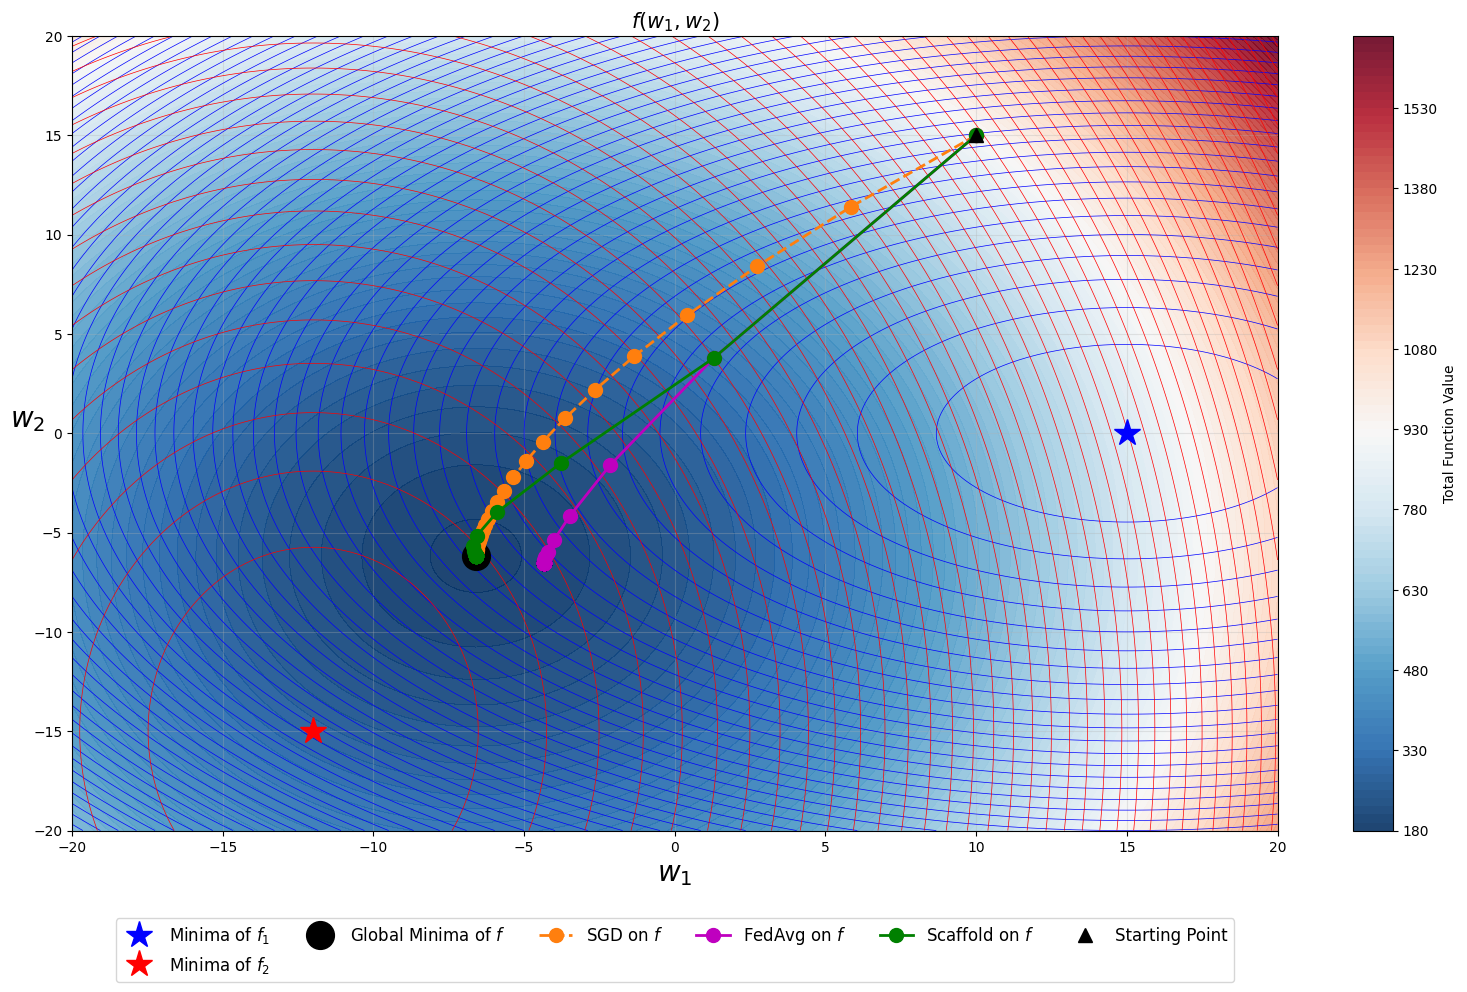

In [44]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')

#starting point

# SGD
SGD_W1 = [x[0] for x in global_trajectory]
SGD_W2 = [x[1] for x in global_trajectory]
plt.plot(SGD_W1, SGD_W2, '--o', color='tab:orange', label='SGD on $f$', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[::], FedAvg_W2[::], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)

#Scaffold
Scaffold_W1 = [x[0] for x in scaffold_trajectory]
Scaffold_W2 = [x[1] for x in scaffold_trajectory]
plt.plot(Scaffold_W1[::], Scaffold_W2[::], 'g-o', label='Scaffold on $f$', linewidth=2, markersize=10)

plt.plot(10, 15, 'k^', markersize=10, label='Starting Point')

plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

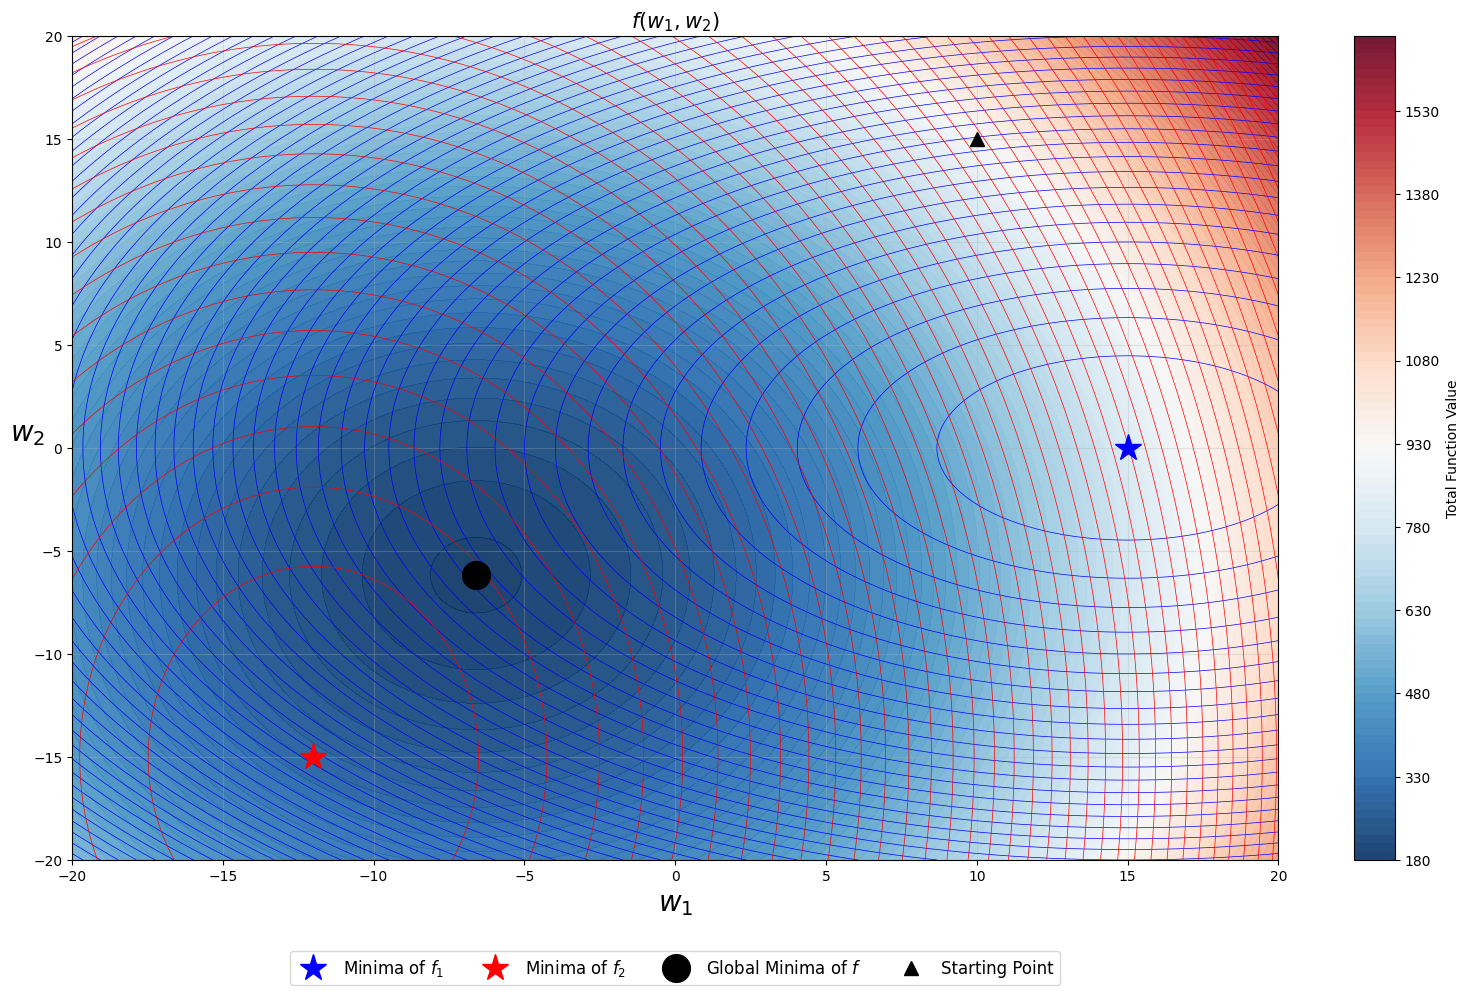

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 10))

# Plot static elements
contour_lines_1 = ax.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 = ax.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
contour = ax.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, ax=ax, label='Total Function Value', orientation='vertical')

# Plot static points
ax.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
ax.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')
ax.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')
ax.plot(10, 15, 'k^', markersize=10, label='Starting Point')

# Labels and legend
ax.set_title("$f(w_1, w_2)$", fontsize=15)
ax.set_xlabel("$w_1$", fontsize=20)
ax.set_ylabel("$w_2$", rotation=0, fontsize=20)
ax.legend(
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=6
)
ax.grid(alpha=0.3)

# Initialize the lines for animation
sgd_line, = ax.plot([], [], '--o', color='tab:orange', label='SGD on $f$', linewidth=2, markersize=10)
fedavg_line, = ax.plot([], [], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)
scaffold_line, = ax.plot([], [], 'g-o', label='Scaffold on $f$', linewidth=2, markersize=10)

# Animation initialization function
def init():
    sgd_line.set_data([], [])
    fedavg_line.set_data([], [])
    scaffold_line.set_data([], [])
    return sgd_line, fedavg_line, scaffold_line

# Animation update function
def update(frame):
    # Update SGD trajectory
    sgd_line.set_data(
        [x[0] for x in global_trajectory[:frame]],
        [x[1] for x in global_trajectory[:frame]]
    )
    # Update FedAvg trajectory
    fedavg_line.set_data(
        [x[0] for x in fedavg_trajectory[:frame]],
        [x[1] for x in fedavg_trajectory[:frame]]
    )
    # Update Scaffold trajectory
    scaffold_line.set_data(
        [x[0] for x in scaffold_trajectory[:frame]],
        [x[1] for x in scaffold_trajectory[:frame]]
    )
    return sgd_line, fedavg_line, scaffold_line

# Create the animation
frames = max(len(global_trajectory), len(fedavg_trajectory), len(scaffold_trajectory))
ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True)

plt.tight_layout()

# Save or display the animation
# To save: ani.save('trajectory_animation.mp4', fps=10, dpi=150)
plt.show()


In [8]:
ani.save('scaffold_trajectory.gif', writer='pillow', fps=2)